## Neural networks for segmentation

In [1]:
import sys
sys.path.append("/home/shirobokov/.local/lib/python3.6/site-packages/")
DATA_PATH = "/home/shirobokov/data/DL_data"
import os

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
%matplotlib inline

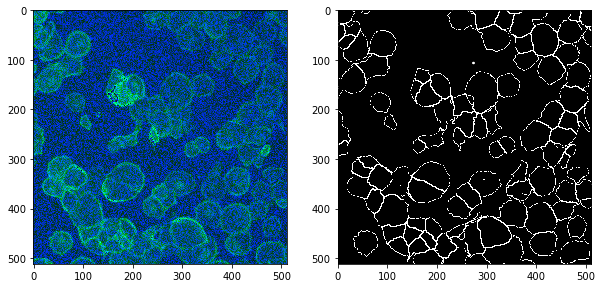

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread(os.path.join(DATA_PATH, 'BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread(os.path.join(DATA_PATH, 'BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def get_data(path=DATA_PATH):
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    for X_filename in os.listdir(os.path.join(path, 'BBBC018_v1_images-fixed', 'train')):
        X_train.append(sp.misc.imread(os.path.join(path, 'BBBC018_v1_images-fixed', 'train', X_filename))[:, :, 1])
        y_filename = X_filename.split('-')[0] + '-cells.png'
        y_train.append(sp.misc.imread(os.path.join(path, 'BBBC018_v1_outlines', 'train', y_filename)))
    
    for X_filename in os.listdir(os.path.join(path, 'BBBC018_v1_images-fixed', 'val')):
        X_val.append(sp.misc.imread(os.path.join(path, 'BBBC018_v1_images-fixed', 'val', X_filename))[:, :, 1])
        y_filename = X_filename.split('-')[0] + '-cells.png'
        y_val.append(sp.misc.imread(os.path.join(path, 'BBBC018_v1_outlines', 'val', y_filename)))
    
    for X_filename in os.listdir(os.path.join(path, 'BBBC018_v1_images-fixed', 'test')):
        X_test.append(sp.misc.imread(os.path.join(path, 'BBBC018_v1_images-fixed', 'test', X_filename))[:, :, 1])
        
    return np.array(X_train, dtype=float) / 255, np.array(y_train, dtype=float) / 255, \
           np.array(X_val,dtype=float) / 255,  np.array(y_val, dtype=float) / 255, \
           np.array(X_test, dtype=float) / 255

def mirror_pad(image):
    padded_image = np.zeros((image.shape[0] + 2 * crop_size, image.shape[1] + 2 * crop_size), dtype=float)
    padded_image[crop_size:-crop_size, crop_size:-crop_size] = image
    padded_image[:crop_size] = padded_image[2 * crop_size:crop_size:-1]
    padded_image[-crop_size:] = padded_image[-crop_size:-2 * crop_size:-1]
    padded_image[:, :crop_size] = padded_image[:, 2 * crop_size:crop_size:-1]
    padded_image[:, -crop_size:] = padded_image[:, -crop_size:-2 * crop_size:-1]
    return padded_image


In [5]:
X_train, y_train, X_val, y_val, X_test = get_data()

In [6]:
imsize=444
crop_size = (572 - 388) // 2 # from https://arxiv.org/pdf/1505.04597.pdf

In [7]:
X_train_pad = []
y_train_pad = []
for i in range(X_train.shape[0]):
    X_train_pad.append(mirror_pad(X_train[i]))
    y_train_pad.append(mirror_pad(y_train[i]))
X_train = np.array(X_train_pad)
y_train = np.array(y_train_pad)

In [8]:
class CellDataset(Dataset):
    def __init__(self, X, y, result_size=imsize):
        self.X = X[:, np.newaxis, :, :]
        self.y = y[:, np.newaxis, :, :]
        self.result_size = result_size
        
    def __getitem__(self, index):
        brightness_shift = np.random.normal(0, 0.1)
        flip_x = np.random.randint(2) * 2 - 1
        flip_y = np.random.randint(2) * 2 - 1
        min_x = np.random.randint(self.X.shape[3] - self.result_size)
        max_x = min_x + self.result_size
        min_y = np.random.randint(self.X.shape[2] - self.result_size)
        max_y = min_y + self.result_size
        if flip_x == -1:
            min_x, max_x = max_x, min_x
        if flip_y == -1:
            min_y, max_y = max_y, min_y
        X_fragment = self.X[index, :, min_y:max_y:flip_y, min_x:max_x:flip_x].copy() + brightness_shift
        y_fragment = self.y[index, :, min_y:max_y:flip_y, min_x:max_x:flip_x].copy()
        return torch.FloatTensor(X_fragment), torch.FloatTensor(y_fragment)
        
    def __len__(self):
        return self.X.shape[0]

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=CellDataset(X_train, y_train),
                                           batch_size=1,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=CellDataset(X_val, y_val),
                                           batch_size=1,
                                           shuffle=True)

Возьмём обычный U-Net, добавим dropout, batch norm, уменьшим размеры слоёв, чтобы сеть влезала в память gpu. Стандартая U-Net после добавления dropout и batch norm перестала влезать в память. Из экономии памяти batch norm добавлен не после каждого сверточного блока, а лишь в 3 местах по всей сети, и dropout тоже вставлен не в каждый сверточный блок.

In [10]:
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=nn.functional.relu, dropout_proba=0.2):
        super(UNetConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size)
        self.activation = activation
        if dropout_proba > 0:
            self.dropout = nn.Dropout(p=dropout_proba)
        else:
            self.dropout = None

    def forward(self, x):
        out = self.activation(self.conv(x))
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.activation(self.conv2(out))

        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=nn.functional.relu, dropout_proba=0.2):
        super(UNetUpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, 2, stride=2)
        self.conv = nn.Conv2d(in_size, out_size, kernel_size)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size)
        self.activation = activation

        if dropout_proba > 0:
            self.dropout = nn.Dropout(p=dropout_proba)
        else:
            self.dropout = None

    def center_crop(self, layer, target_size):
        batch_size, n_channels, layer_width, layer_height = layer.size()
        xy1 = (layer_width - target_size) // 2
        return layer[:, :, xy1:(xy1 + target_size), xy1:(xy1 + target_size)]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.size()[2])
        
        out = torch.cat([up, crop1], 1)
        out = self.activation(self.conv(out))
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.activation(self.conv2(out))
        #print("up_shape:", up.shape, 'bridge_shape:', bridge.shape, 'crop_shape:',
        #      crop1.shape, 'out_shape:', out.shape)

        return out


class UNet(nn.Module):
    def __init__(self, imsize):
        super(UNet, self).__init__()
        self.imsize = imsize

        self.activation = nn.functional.relu
        
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        
        
        self.batchnorm0 = nn.BatchNorm2d(1)
        self.batchnorm3 = nn.BatchNorm2d(192)
        self.batchnorm7 = nn.BatchNorm2d(192)

        self.conv_block1_64 = UNetConvBlock(1, 48, dropout_proba=0)
        self.conv_block64_128 = UNetConvBlock(48, 96, dropout_proba=0.15)
        self.conv_block128_256 = UNetConvBlock(96, 192, dropout_proba=0.18)
        self.conv_block256_512 = UNetConvBlock(192, 384, dropout_proba=0.2)
        self.conv_block512_1024 = UNetConvBlock(384, 768, dropout_proba=0)

        self.up_block1024_512 = UNetUpBlock(768, 384, dropout_proba=0)
        self.up_block512_256 = UNetUpBlock(384, 192, dropout_proba=0.25)
        self.up_block256_128 = UNetUpBlock(192, 96, dropout_proba=0.2)
        self.up_block128_64 = UNetUpBlock(96, 48, dropout_proba=0.2)

        self.conv1d = nn.Conv2d(48, 1, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.batchnorm0(x)
        block1 = self.conv_block1_64(x)
        
        #print('b4 pool1 shape =', block1.shape)
        pool1 = self.pool1(block1)

        block2 = self.conv_block64_128(pool1)
        #print('b4 pool2 shape =', block2.shape)
        pool2 = self.pool2(block2)

        block3 = self.conv_block128_256(pool2)
        #print('b4 pool3 shape =', block3.shape)
        pool3 = self.batchnorm3(self.pool3(block3))

        block4 = self.conv_block256_512(pool3)
        #print('b4 pool4 shape =', block4.shape)
        pool4 = self.pool4(block4)

        block5 = self.conv_block512_1024(pool4)
        
        #print('b4 up shape =', block5)

        up1 = self.up_block1024_512(block5, block4)

        up2 = self.batchnorm7(self.up_block512_256(up1, block3))

        up3 = self.up_block256_128(up2, block2)

        up4 = self.up_block128_64(up3, block1)
        

        out = self.conv1d(up4)
        #print('out:', out)
        return out # return self.sigmoid(out)

In [11]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [12]:
times_augmentation = 1
train_batches_pool = []
for i in range(times_augmentation):
    for element in train_loader:
        train_batches_pool.append(element)
        
val_batches_pool = []
for i in range(times_augmentation):
    for element in val_loader:
        val_batches_pool.append(element)

### реализуем численно стабильную композицию взвешенного bce_loss и sigmoid:

In [25]:
def weighted_bce_loss_with_logits(output, target, weights):
    max_val = (-output).clamp(min=0)
    loss = weights[0] * (1 - target) * output + (weights[1] * target + weights[0] * (1 - target)) * (
        max_val + (torch.exp(-max_val) + torch.exp(-output - max_val)).log()
    )
    return torch.mean(loss)

In [15]:
def exp_lr_update(optimizer, epoch, init_lr=3e-4, decay=0.85, decay_preiod=10):
    lr = init_lr * (decay ** (epoch // decay_preiod))

    if epoch % decay_preiod == 0:
        print('LR is set to %f' % lr)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def train(model, start_lr=3e-4, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
    for epoch in range(epochs):
        exp_lr_update(optimizer, epoch, init_lr=start_lr, decay=0.85)
        train_epoch(epoch, model, train_loader, optimizer)
        test_epoch(epoch, model, val_loader)


def train_epoch(epoch, model, data_loader, optimizer):
    model.train()
    iou = 0
    train_loss = 0
    for data, target in data_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        optimizer.zero_grad()
        output = model(data)
        #print('output =', output)
        #print('out shape =', output.shape)
        #print(((output - target[:, :, crop_size:imsize-crop_size, crop_size:imsize-crop_size]) ** 2).sum())
        loss = weighted_bce_loss_with_logits(
            output, target[:, :, crop_size:imsize-crop_size, crop_size:imsize-crop_size], class_weights)
        train_loss += loss
        #loss.backward(retain_graph=True)
        loss.backward()
        iou += calc_iou(np.array(output.data) - threshold,
                        np.array(target[:, :, crop_size:imsize-crop_size,
                                        crop_size:imsize-crop_size].data))

        #print('loss =', loss)
        #print(output - target[:, :, crop_size:imsize-crop_size, crop_size:imsize-crop_size])
        optimizer.step()
            
    train_loss /= len(data_loader)
    iou /= len(data_loader)
    print('\n%d epoch train set: loss = %.4f, iou = %.4f' %(epoch, float(train_loss), iou))


def test_epoch(epoch, model, data_loader):
    model.eval()
    test_loss = 0
    iou = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda()
        output = model(data)
        #print(test_loss)
        test_loss += weighted_bce_loss_with_logits(
            output, target[:, :, crop_size:imsize-crop_size, crop_size:imsize-crop_size],
            class_weights)
        iou += calc_iou(np.array(output.data) - threshold,
                        np.array(target[:, :, crop_size:imsize-crop_size,
                                        crop_size:imsize-crop_size].data))
        
    test_loss /= len(data_loader)
    iou /= len(data_loader)
    print('%d epoch val set: loss = %.4f, iou = %.4f' % (epoch, float(test_loss), iou))

In [16]:
%env CUDA_VISIBLE_DEVICES=0,2,3
%env LIBRARY_PATH=/usr/local/cuda/lib64

env: CUDA_VISIBLE_DEVICES=0,2,3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [26]:
model = UNet(imsize=imsize).cuda()

In [27]:
class_weights = [1, 3]
threshold = 0.49

### Обучим сеть:

In [28]:
train(model, start_lr=4e-4, epochs=200)

LR is set to 0.000400

0 epoch train set: loss = 0.4207, iou = 0.0000
0 epoch val set: loss = 0.4337, iou = 0.0000

1 epoch train set: loss = 0.2677, iou = 0.0000
1 epoch val set: loss = 0.5129, iou = 0.0000

2 epoch train set: loss = 0.2931, iou = 0.0000
2 epoch val set: loss = 0.3892, iou = 0.0000

3 epoch train set: loss = 0.2640, iou = 0.0000
3 epoch val set: loss = 0.3442, iou = 0.0000

4 epoch train set: loss = 0.2518, iou = 0.0000
4 epoch val set: loss = 0.3783, iou = 0.0000

5 epoch train set: loss = 0.2535, iou = 0.0000
5 epoch val set: loss = 0.3755, iou = 0.0000

6 epoch train set: loss = 0.2316, iou = 0.0234
6 epoch val set: loss = 0.3722, iou = 0.0166

7 epoch train set: loss = 0.2348, iou = 0.0435
7 epoch val set: loss = 2.3457, iou = 0.0534

8 epoch train set: loss = 0.2216, iou = 0.0675
8 epoch val set: loss = 0.3324, iou = 0.0138

9 epoch train set: loss = 0.2160, iou = 0.0927
9 epoch val set: loss = 0.3190, iou = 0.0783
LR is set to 0.000340

10 epoch train set: loss 

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys



72 epoch train set: loss = 0.1851, iou = nan
72 epoch val set: loss = 0.3486, iou = 0.2002

73 epoch train set: loss = 0.1755, iou = nan
73 epoch val set: loss = 0.3228, iou = 0.1999

74 epoch train set: loss = 0.1819, iou = 0.2946
74 epoch val set: loss = 0.2942, iou = 0.1962

75 epoch train set: loss = 0.1772, iou = 0.2888
75 epoch val set: loss = 0.3971, iou = 0.1351

76 epoch train set: loss = 0.1849, iou = 0.2935
76 epoch val set: loss = 0.3652, iou = 0.1579

77 epoch train set: loss = 0.1690, iou = 0.2882
77 epoch val set: loss = 0.3020, iou = 0.1181

78 epoch train set: loss = 0.1814, iou = 0.2900
78 epoch val set: loss = 0.2837, iou = 0.1731

79 epoch train set: loss = 0.1783, iou = 0.2922
79 epoch val set: loss = 0.2529, iou = 0.2229
LR is set to 0.000109

80 epoch train set: loss = 0.1860, iou = 0.2925
80 epoch val set: loss = 0.3190, iou = 0.1324

81 epoch train set: loss = 0.1691, iou = nan
81 epoch val set: loss = 0.2809, iou = 0.1877

82 epoch train set: loss = 0.1777, i

155 epoch val set: loss = 0.5537, iou = 0.1994

156 epoch train set: loss = 0.1729, iou = 0.3082
156 epoch val set: loss = 0.3565, iou = 0.1727

157 epoch train set: loss = 0.1756, iou = 0.3093
157 epoch val set: loss = 0.3219, iou = 0.1399

158 epoch train set: loss = 0.1746, iou = 0.3097
158 epoch val set: loss = 0.2506, iou = 0.2650

159 epoch train set: loss = 0.1842, iou = 0.3086
159 epoch val set: loss = 0.4188, iou = 0.1157
LR is set to 0.000030

160 epoch train set: loss = 0.1655, iou = 0.3153
160 epoch val set: loss = 0.2781, iou = 0.1252

161 epoch train set: loss = 0.1587, iou = 0.3167
161 epoch val set: loss = 0.4842, iou = 0.2068

162 epoch train set: loss = 0.1716, iou = 0.3084
162 epoch val set: loss = 0.2785, iou = 0.1597

163 epoch train set: loss = 0.1697, iou = 0.3096
163 epoch val set: loss = 0.3734, iou = 0.1890

164 epoch train set: loss = 0.1553, iou = 0.3154
164 epoch val set: loss = 0.5773, iou = 0.1688

165 epoch train set: loss = 0.1768, iou = 0.3077
165 epoc

Поскольку при обучении использовалась аугментация, метрики были занижены (т.к. они считались на "испорченных" картинках). Ниже посчитано качество по всей валидационной выборке. Перед прогоном через сеть каждая картинка была разбита на 4 части. Каждая часть сегментировалась отдельно.

In [31]:
def predict(image, threshold=0, extra_size=4):
    padded_img = mirror_pad(image)
    #print(padded_img.shape)
    puzzle_size = 2
    piece_size = image.shape[0]  // puzzle_size
    #print(piece_size, piece_size + 2 * crop_size)
    result = np.zeros((image.shape[0], image.shape[1]))
    for piece_x_id in range(puzzle_size):
        for piece_y_id in range(puzzle_size):
            if piece_x_id != puzzle_size - 1:
                x_limits = [piece_size * piece_x_id, piece_size * (piece_x_id + 1) + 2 * crop_size + extra_size]
            else:
                x_limits = [piece_size * piece_x_id - extra_size, piece_size * (piece_x_id + 1) + 2 * crop_size]
            if piece_y_id != puzzle_size - 1:
                y_limits = [piece_size * piece_y_id, piece_size * (piece_y_id + 1) + 2 * crop_size + extra_size]
            else:
                y_limits = [piece_size * piece_y_id - extra_size, piece_size * (piece_y_id + 1) + 2 * crop_size]
            #print('y_limits = ', y_limits)
            piece = padded_img[y_limits[0]:y_limits[1], x_limits[0]:x_limits[1]]
            #print('piece.shape =', piece.shape)
            result[y_limits[0]:y_limits[1] - 2 * crop_size,
                   x_limits[0]:x_limits[1] - 2 * crop_size] = np.array(model(
                Variable(torch.FloatTensor(piece[np.newaxis, np.newaxis, :, :])).cuda()).data)
    return result > threshold

In [55]:
scores = [calc_iou(predict(X_val[i], threshold=threshold), y_val[i]) for i in range(X_val.shape[0])] 
print('val iou score = %f' % np.mean(scores))

val iou score = 0.302052


### Результаты:
iou на валидационной выборке > 0.3.

ниже представлены слава направо: исходная картинка из валидационной выборки, наше предсказание и правильный ответ

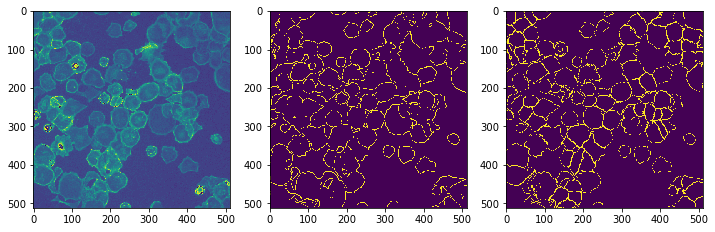

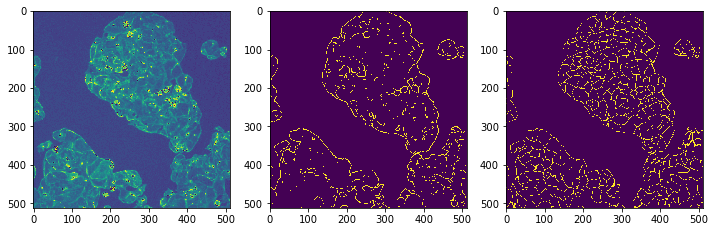

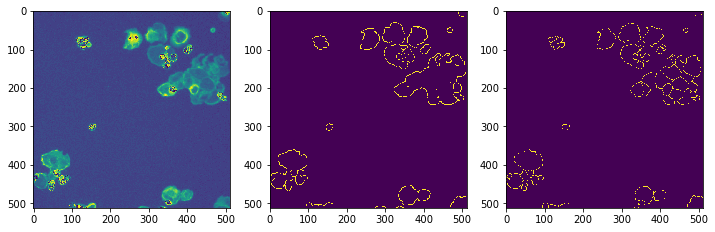

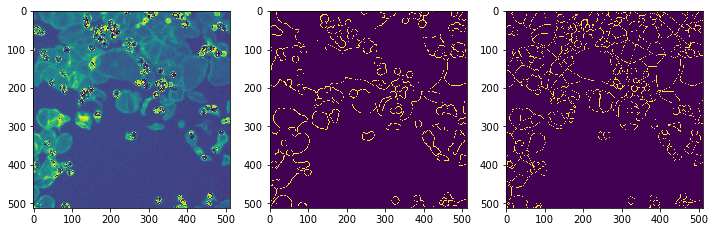

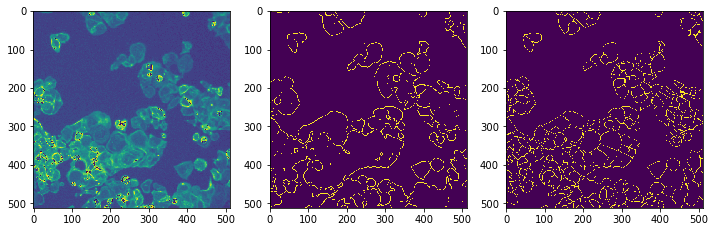

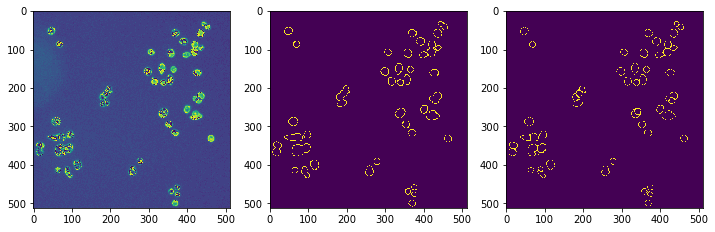

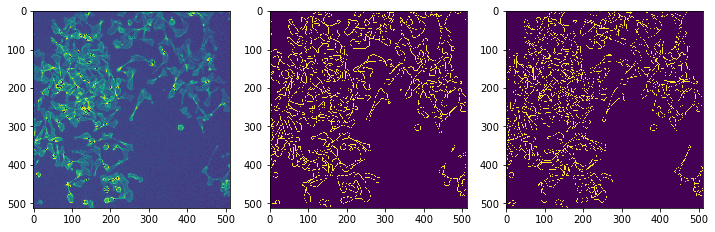

In [47]:
for i in range(X_val.shape[0]):
    img = X_val[i]
    target = y_val[i]

    plt.figure(figsize=(12, 35))
    plt.subplot(i + 1, 3, 1)
    plt.imshow(img)
    
    plt.subplot(i + 1, 3, 2)
    plt.imshow(predict(img, threshold=threshold))
    
    plt.subplot(i + 1, 3, 3)
    plt.imshow(target)

In [54]:
for i, img in enumerate(X_test):
    scipy.misc.imsave(str(i) + '.png', predict(img).astype(float))